In [151]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re as re
import seaborn as sns
np.random.seed(28)

from subprocess import check_output

# Any results you write to the current directory are saved as output.

### Load Data and Exploration Analysis

In [152]:
titanic = pd.read_csv('train.csv')

In [153]:
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [112]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [113]:
titanic["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [114]:
titanic["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [115]:
# encode categorical attributes
titanic["Sex_enc"] = titanic["Sex"].map({"female":1, "male": 0}) # encode sex
titanic["Embarked_enc"] = titanic["Embarked"].map({"S":0, "C":1, "Q":2}) # encode Embarked

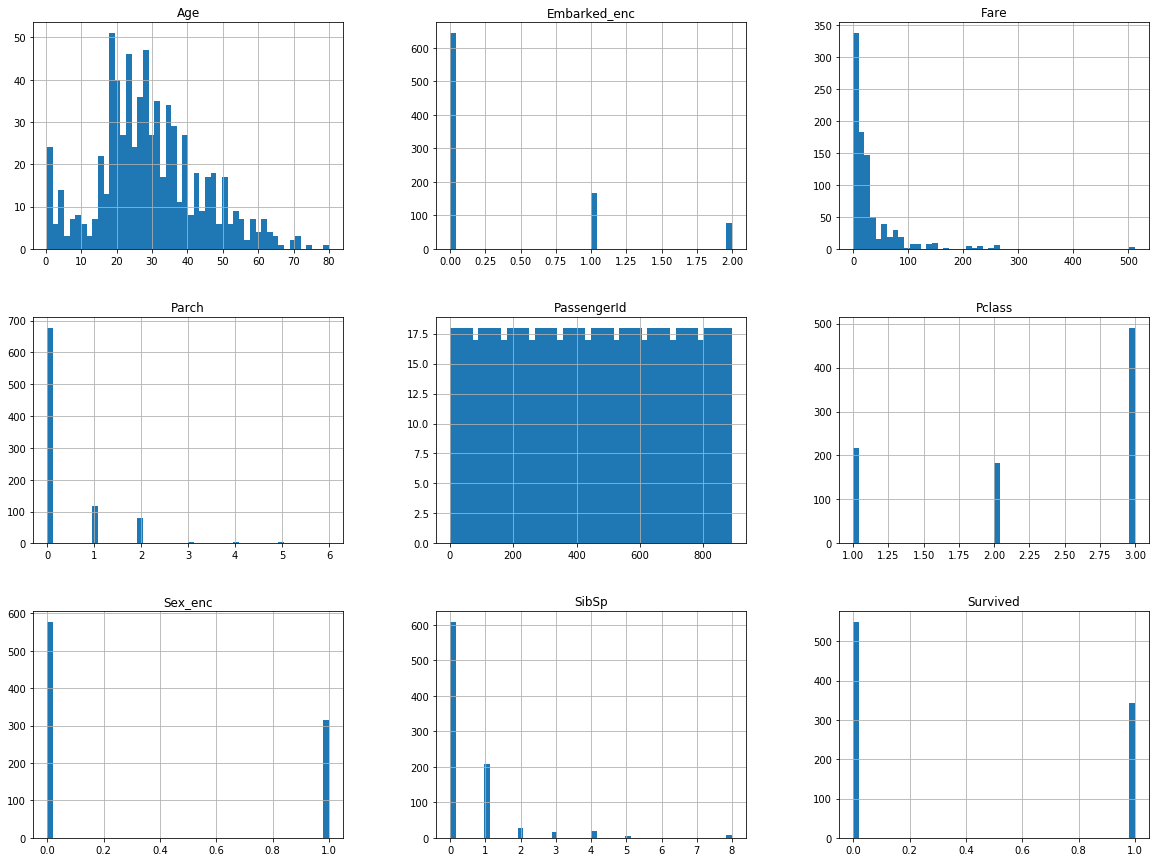

In [116]:
# Take a look at the distribution of all feature values
%matplotlib inline
titanic.hist(bins=50, figsize=(20,15))
plt.show()

A few observations: 

* Attributes have very different scales - need to be standardized
* Sex, Embarked, Parch, Pclass and SibSp take discrete distributions, Age and Fare take continuous distributions
* Name, Ticket, Cabin are not plotted

#### Sex, Pclass, Parch, SibSp, Embarked

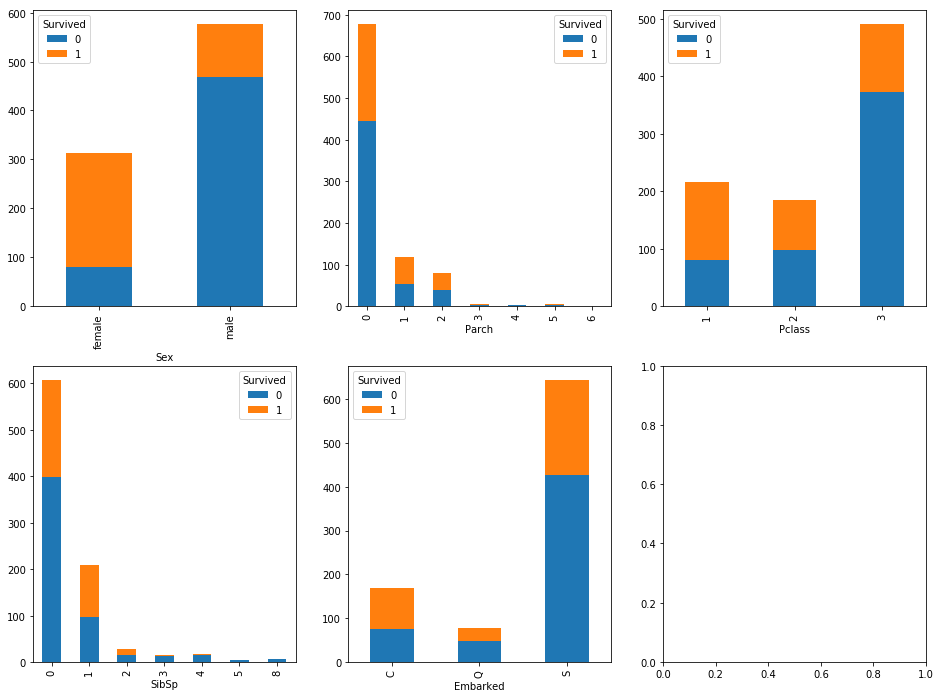

In [117]:
# Take a look at how Embarked, Parch, Pclass, SibSp and Sex are associated with Survived
fig, axes = plt.subplots(2,3, figsize=(16,12))
attr_ls = ["Sex", "Parch", "Pclass", "SibSp", "Embarked"]
for attr, ax in zip(attr_ls[:3], axes[0]):
    titanic.pivot_table("PassengerId", attr, "Survived", "count").plot(kind="bar", stacked=True, ax=ax)
for attr, ax in zip(attr_ls[3:], axes[1]):
    titanic.pivot_table("PassengerId", attr, "Survived", "count").plot(kind="bar", stacked=True, ax=ax) 

* Female is more likely to survive than male
* Parch seems not to be a significant factor
* Passengers in the third class are more likely to perish
* SibSp seems not be a siginificant factor
* Passengers who embarked at S are more likely to perish

Lets see the linear relationships between one or more relationships between these variables.

In [118]:
# verify the observations with correlation matrix
corr = titanic[["Survived", "Sex_enc", "Parch", "Pclass", "SibSp", "Embarked_enc"]].corr()
np.abs(corr["Survived"]).sort_values(ascending=False)

Survived        1.000000
Sex_enc         0.543351
Pclass          0.338481
Embarked_enc    0.108669
Parch           0.081629
SibSp           0.035322
Name: Survived, dtype: float64

In [119]:
# what about combining SibSp and Parch
titanic["family_size"] = titanic["Parch"] + titanic["SibSp"]
titanic[["Survived", "family_size"]].corr()["Survived"]

Survived       1.000000
family_size    0.016639
Name: Survived, dtype: float64

In [120]:
# family size is not more correlated than Parch and SibSp, so delete it
titanic.drop("family_size", axis=1, inplace=True)

#### Age and Fare

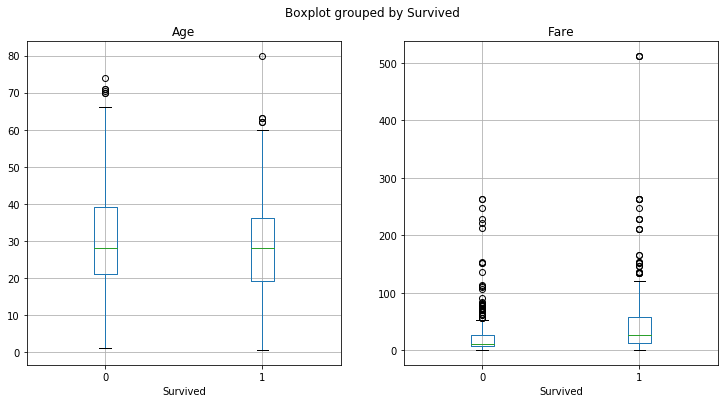

In [121]:
# take a look at the numeric features Age, Fare
fig, axes = plt.subplots(1,2,figsize=(12,6))
titanic.boxplot(by="Survived", column="Age", ax=axes[0])
titanic.boxplot(by="Survived", column="Fare", ax=axes[1])
plt.show()

* Survived passengers are slightly younger than those perished
* The fares of Survived passengers have higher value than that of perished passengeres

In [122]:
# still take a look at the correlation
titanic[["Survived", "Fare", "Age"]].corr()["Survived"]

Survived    1.000000
Fare        0.257307
Age        -0.077221
Name: Survived, dtype: float64

#### Title, Ticket and Cabin

In [123]:
# Extract title from Name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
non_rare = ["Mr", "Miss", "Mrs", "Master"] # non rare titles
title = titanic["Name"].map(get_title)
title = np.where(title.isin(non_rare), title, "Rare")
titanic["Title"] = title

In [124]:
titanic["Title"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64

In [125]:
def extract_cabin(cabin):
    split = re.split("\s", cabin)        
    cabin_letter = [s[0] for s in split]
    if len(set(cabin_letter)) == 1: # if the elements in the list are the same, 
        return cabin_letter[0] # return the element
    else:
        return "M" # otherwise return "M"
titanic["Cabin_letter"] = titanic["Cabin"].map(lambda x: "U" if pd.isnull(x) else extract_cabin(x))

In [126]:
titanic["Cabin_letter"].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F      9
G      4
M      4
T      1
Name: Cabin_letter, dtype: int64

In [127]:
def ticket_len(ticket):
    split = re.split("\s", ticket)
    return len(split[-1])
titanic["Ticket_len"] = titanic["Ticket"].map(ticket_len)
titanic["Ticket_len"].value_counts()

6    423
5    246
4    169
7     44
3      7
1      2
Name: Ticket_len, dtype: int64

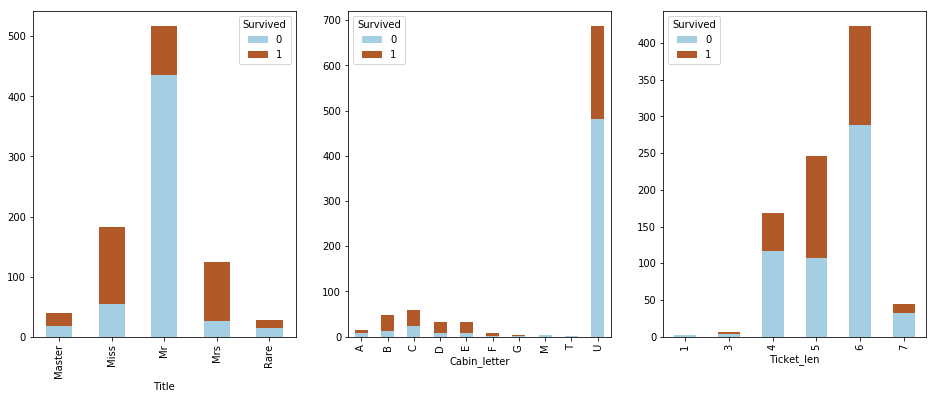

In [128]:
# lets plot Title, Cabin_letter and Ticket_len
fig, axes = plt.subplots(1,3,  figsize=(16, 6))
attr_ls = ["Title", "Cabin_letter", "Ticket_len"]
for ax, attr in zip(axes, attr_ls):
    titanic.pivot_table("PassengerId", attr, "Survived", "count").plot(kind="bar", stacked=True, colormap="Paired", ax=ax)

* Mrs are more likely to perish, which is consistent with the previous analysis that males are more possible to perish
* Cabins seems not to be an important feature
* Ticket length seems not to be an important feature

In [129]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_enc,Embarked_enc,Title,Cabin_letter,Ticket_len
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0.0,Mr,U,5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1.0,Mrs,C,5
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0.0,Miss,U,7
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0.0,Mrs,C,6
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0.0,Mr,U,6
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,2.0,Mr,U,6
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0,0.0,Mr,E,5
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0,0.0,Master,U,6
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1,0.0,Mrs,U,6
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,1.0,Mrs,U,6


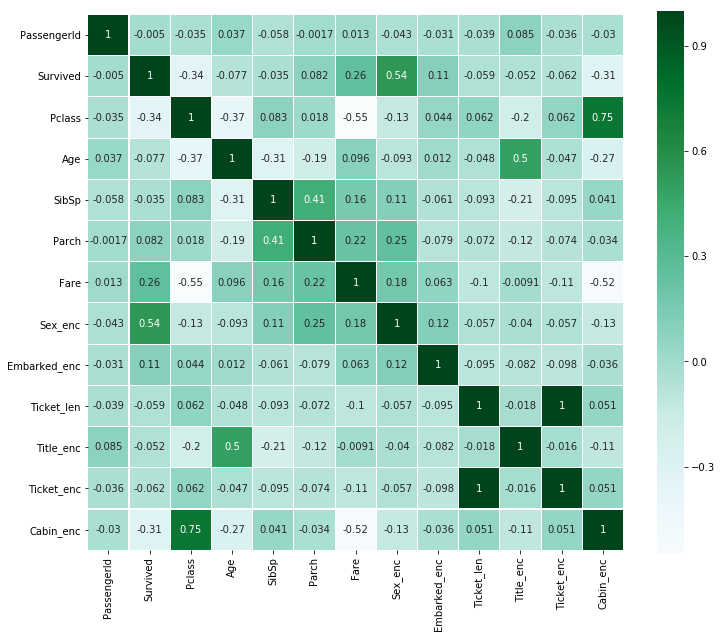

In [130]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
titanic["Title_enc"] = encoder.fit_transform(titanic["Title"])
titanic["Ticket_enc"] = encoder.fit_transform(titanic["Ticket_len"])
titanic["Cabin_enc"] = encoder.fit_transform(titanic["Cabin_letter"])
corr = titanic.corr()
fig = plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='BuGn', linewidths=0.1,vmax=1.0, square=True, annot=True)
plt.show()

* The features are that highly corrected with Survived include Pclass, Fare, Sex_enc, Cabin_enc
* Title is another important feature but since it is categorical, it is not linearly correlated with Survived
* Cabin_enc and Pclass are highly correlated, maybe we can fill the missing values in Cabin with Pclass

In [141]:
targets = titanic['Survived']

In [144]:
#Filling out NaN values of age in data
title_mean_age=[]
title_mean_age.append(list(set(titanic.Name)))  #set for unique values of the title, and transform into list
title_mean_age.append(titanic.groupby('Name').Age.mean())
title_mean_age

[['Moore, Mr. Leonard Charles',
  'Brown, Miss. Amelia "Mildred"',
  'Smart, Mr. John Montgomery',
  'Robbins, Mr. Victor',
  'Madsen, Mr. Fridtjof Arne',
  'Astor, Mrs. John Jacob (Madeleine Talmadge Force)',
  'Gustafsson, Mr. Anders Vilhelm',
  'Connors, Mr. Patrick',
  'Oreskovic, Miss. Marija',
  'Johnson, Mr. Alfred',
  'Lang, Mr. Fang',
  'Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")',
  'Gilinski, Mr. Eliezer',
  'Meyer, Mrs. Edgar Joseph (Leila Saks)',
  'Garside, Miss. Ethel',
  'Naidenoff, Mr. Penko',
  'Hart, Mrs. Benjamin (Esther Ada Bloomfield)',
  'Sirota, Mr. Maurice',
  'McCarthy, Mr. Timothy J',
  'Mallet, Mr. Albert',
  'Hoyt, Mr. William Fisher',
  'Toufik, Mr. Nakli',
  'Sedgwick, Mr. Charles Frederick Waddington',
  'Butt, Major. Archibald Willingham',
  'Bowerman, Miss. Elsie Edith',
  'Connaghton, Mr. Michael',
  'Sirayanian, Mr. Orsen',
  'Davies, Master. John Morgan Jr',
  'Abelson, Mrs. Samuel (Hannah Wizosky)',
  'Ponesell, Mr. Martin',


In [145]:
n_traning= titanic.shape[0]   #number of rows
n_titles= len(title_mean_age[1])
for i in range(0, n_traning):
    if np.isnan(titanic.Age[i])==True:
        for j in range(0, n_titles):
            if titanic.Name[i] == title_mean_age[0][j]:
                titanic.Age[i] = title_mean_age[1][j]

In [146]:
#Convert age into Adult and Youth
for i in range(0, n_traning):
    if titanic.Age[i] > 18:
        titanic.Age[i]= 0
    else:
        titanic.Age[i]= 1

C:\Users\Mahesh.Bhosale\AppData\Local\Continuum\anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [147]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_enc,Embarked_enc,Title,Cabin_letter,Ticket_len,Title_enc,Ticket_enc,Cabin_enc
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,NaN,S,0,0.0,Mr,U,5,2,3,9
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1.0,1,0,PC 17599,71.2833,C85,C,1,1.0,Mrs,C,5,3,3,2
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0.0,Miss,U,7,1,5,9
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1.0,1,0,113803,53.1000,C123,S,1,0.0,Mrs,C,6,3,4,2
4,5,0,3,"Allen, Mr. William Henry",male,1.0,0,0,373450,8.0500,NaN,S,0,0.0,Mr,U,6,2,4,9
5,6,0,3,"Moran, Mr. James",male,1.0,0,0,330877,8.4583,NaN,Q,0,2.0,Mr,U,6,2,4,9
6,7,0,1,"McCarthy, Mr. Timothy J",male,1.0,0,0,17463,51.8625,E46,S,0,0.0,Mr,E,5,2,3,4
7,8,0,3,"Palsson, Master. Gosta Leonard",male,1.0,3,1,349909,21.0750,NaN,S,0,0.0,Master,U,6,0,4,9
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,1.0,0,2,347742,11.1333,NaN,S,1,0.0,Mrs,U,6,3,4,9
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,1.0,1,0,237736,30.0708,NaN,C,1,1.0,Mrs,U,6,3,4,9


In [148]:
final_data = titanic.drop(labels=['Name','Sex','PassengerId','Ticket','Cabin','Embarked','Title','Cabin_letter','Ticket_len','Survived'], axis=1)

In [140]:
final_data

,Pclass,Age,SibSp,Parch,Fare,Sex_enc,Embarked_enc,Title_enc,Ticket_enc,Cabin_enc
0,3,0.0,1,0,7.2500,0,0.0,2,3,9
1,1,0.0,1,0,71.2833,1,1.0,3,3,2
2,3,0.0,0,0,7.9250,1,0.0,1,5,9
3,1,0.0,1,0,53.1000,1,0.0,3,4,2
4,3,0.0,0,0,8.0500,0,0.0,2,4,9
5,3,0.0,0,0,8.4583,0,2.0,2,4,9
6,1,0.0,0,0,51.8625,0,0.0,2,3,4
7,3,1.0,3,1,21.0750,0,0.0,0,4,9
8,3,0.0,0,2,11.1333,1,0.0,3,4,9
9,2,1.0,1,0,30.0708,1,1.0,3,4,9


In [188]:
final_data.to_csv('processed_data.csv', index=False)